# Inspiration

https://arxiv.org/abs/1710.06071

https://arxiv.org/abs/1612.05251

# Grab Data

In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [2]:
# Exploration Set
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt   test.txt  train.txt


In [1]:
import os

exploration_directory = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'
os.listdir(exploration_directory)

['dev.txt', 'train.txt', 'test.txt']

# Preprocess

In [2]:
def read_lines(filename):
    with open(filename, 'r') as file:
        return file.readlines()

In [3]:
train_lines = read_lines(os.path.join(exploration_directory, 'train.txt'))

In [4]:
def preprocess_text(filename):
    """
    Converts every line into dictionaries
    """
    input_lines = read_lines(filename)
    abstract_lines = ''
    abstract_samples = []
    
    for line in input_lines:
        if line.startswith('###'):
            abstract_id = line
            abstract_lines = ''
        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines()
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {}
                target_text_split = abstract_line.split('\t')
                line_data['target'] = target_text_split[0]
                line_data['text'] = target_text_split[1].lower()
                line_data['line_number'] = abstract_line_number
                line_data['total_lines'] = len(abstract_line_split) - 1
                abstract_samples.append(line_data)
        else:
            abstract_lines += line
    return abstract_samples

In [5]:
%%time
train_samples = preprocess_text(os.path.join(exploration_directory, 'train.txt'))
val_samples = preprocess_text(os.path.join(exploration_directory, 'dev.txt'))
test_samples = preprocess_text(os.path.join(exploration_directory, 'test.txt'))
len(train_lines), len(val_samples), len(test_samples)

CPU times: user 210 ms, sys: 28.8 ms, total: 239 ms
Wall time: 246 ms


(210040, 30212, 30135)

In [6]:
train_samples

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

# Organise and Explore Data

In [7]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
...,...,...,...,...
180035,RESULTS,for the absolute change in percent atheroma vo...,7,11
180036,RESULTS,"for pav , a significantly greater percentage o...",8,11
180037,RESULTS,both strategies had acceptable side effect pro...,9,11
180038,CONCLUSIONS,"compared with standard statin monotherapy , th...",10,11


In [10]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<Axes: ylabel='Frequency'>

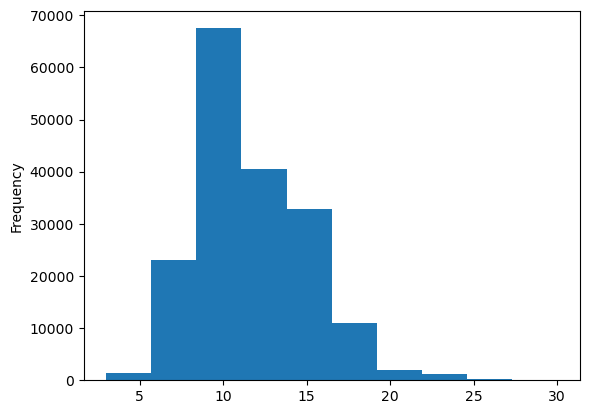

In [11]:
train_df.total_lines.plot.hist()

In [8]:
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

In [13]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

# Prepare data for model

## 1. One Hot Encoder

In [9]:
import tensorflow as tf

In [10]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1, 1))

val_labels_one_hot

/Users/tacocat/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [11]:
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

## 2. Label Encoder

In [11]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

In [12]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [13]:
n_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
n_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Modelling Experiments

## 0. Baseline (TF-IDF Nultinomial Naive Bayes Classifier)

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('classifier', MultinomialNB())
])

model_0.fit(X=train_sentences, y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('classifier', MultinomialNB())])

In [21]:
model_0.score(X=val_sentences, y=val_labels_encoded)

0.7218323844829869

In [51]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def calculate_results(y_true, y_pred):
    """
    Calculates model accuracy, precision, recall and f1 score of a binary classification model.

    Args:
        y_true: true labels in the form of a 1D array
        y_pred: predicted labels in the form of a 1D array

    Returns a dictionary of accuracy, precision, recall, f1-score.
    """
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, 
                                                                                 y_pred, 
                                                                                 average="weighted")
    model_results = {"accuracy": model_accuracy,
                      "precision": model_precision,
                      "recall": model_recall,
                      "f1": model_f1}
    return model_results

In [23]:
baseline_preds = model_0.predict(val_sentences)
calculate_results(val_labels_encoded, baseline_preds)

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Prepare data for deep learning models

In [14]:
import numpy as np
from tensorflow.keras import layers

In [15]:
# To make sentence lengths consistent
sentence_lengths = [len(sentence.split()) for sentence in train_sentences]
average_sentence_length = np.mean(sentence_lengths)

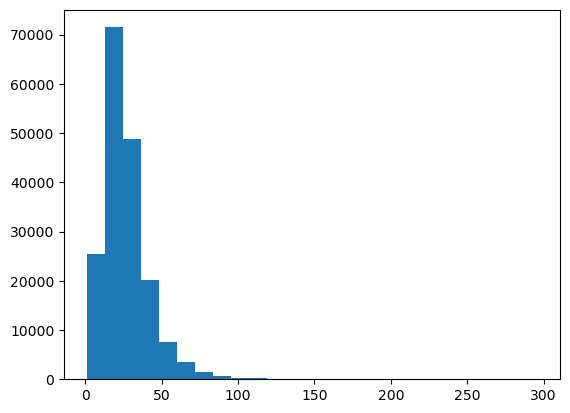

In [26]:
import matplotlib.pyplot as plt
plt.hist(sentence_lengths, bins=25);

In [16]:
output_sequence_length = int(np.percentile(sentence_lengths, 95))
output_sequence_length, max(sentence_lengths)

# Sentence length of 55 covers 95% of the data

(55, 296)

## Text Vectorisation Layer

In [17]:
max_tokens = 68000 # From paper

In [18]:
# Create Layer

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_sequence_length)

In [23]:
# Plug sentences into vectoriser

text_vectorizer.adapt(train_sentences)

In [24]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()

In [32]:
print(f'Number of words in vocab:\n {len(rct_20k_text_vocab)}')
print(f'Most common words:\n {rct_20k_text_vocab[:5]}')
print(f'Least common words:\n {rct_20k_text_vocab[-5:]}')

Number of words in vocab:
 64841
Most common words:
 ['', '[UNK]', 'the', 'and', 'of']
Least common words:
 ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [33]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

## Token Embedding Layer

In [25]:
token_embedder = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                                   output_dim=128,
                                   mask_zero=True,
                                   name='token_embedding')

In [26]:
import random

In [27]:

target_sentence = random.choice(train_sentences)
print(f'Text:\n {target_sentence}')
print(f'\nLength of text: {len(target_sentence)}')
print(f'\nVectorised: {text_vectorizer([target_sentence])}')
print(f'\nEmbedded: {token_embedder(text_vectorizer([target_sentence]))}')

Text:
 maintenance of euglycemic control and antiplatelet therapy are therefore regarded as effective primary prevention in this group .

Length of text: 129

Vectorised: [[ 627    4 9712   35    3 2464   66   58  709 5485   25  137   56  403
     5   23   13    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Embedded: [[[-0.02626511  0.04797501  0.03461598 ... -0.03443446  0.03142859
    0.04942024]
  [ 0.00197308 -0.00793817  0.00100647 ... -0.03839678 -0.02610987
    0.03209639]
  [ 0.00407885 -0.03246041 -0.04854286 ... -0.03106361  0.03086187
    0.00486339]
  ...
  [-0.00317706 -0.01995939  0.04201544 ... -0.01433315  0.02292665
   -0.03563535]
  [-0.00317706 -0.01995939  0.04201544 ... -0.01433315  0.02292665
   -0.03563535]
  [-0.00317706 -0.01995939  0.04201544 ... -0.01433315  0.02292665
   -0.03563535]]]


## Create TF Datasets

In [28]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset, val_dataset, test_dataset

(<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>,
 <_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>,
 <_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>)

In [29]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset, val_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

## 1. Conv1D

In [39]:
def model1():
    inputs = layers.Input(shape=(1,), dtype=tf.string)
    text_vectors = text_vectorizer(inputs)
    token_embeddings = token_embedder(text_vectors)
    
    x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(token_embeddings)
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.legacy.Adam(),
                  metrics=['accuracy'])
    
    model.summary()
    history = model.fit(train_dataset,
                        steps_per_epoch=int(0.1*len(train_dataset)), # look at only 10% of the data while experimenting
                        validation_data=val_dataset,
                        validation_steps=int(0.1*len(val_dataset)),
                        epochs=3
                       )
    
    model_predict_probs = model.predict(val_dataset)
    model_preds = tf.argmax(model_predict_probs, axis=1)
    
    model_results = calculate_results(y_true=val_labels_encoded, y_pred=model_preds)
    
    return history, model_results

In [40]:
_, model1_results = model1()
model1_results

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

{'accuracy': 78.343042499669,
 'precision': 0.7795936665495273,
 'recall': 0.78343042499669,
 'f1': 0.7808680526239649}

## 2.  Univeral Sentence Encoder - Pretrained Embeddings

In [30]:
import tensorflow_hub as hub

In [42]:
cmlm_base = 'https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/cmlm-en-base/versions/1'
use = 'https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2'

use_embedding_layer = hub.KerasLayer(use,
                               input_shape=[],
                               dtype=tf.string)
dummy_sentence = "The quick brown fox jumps over the lazy dog."

embeddings = use_embedding_layer([
    "The quick brown fox jumps over the lazy dog.",
    "I am a sentence for which I would like to get its embedding"])

print(embeddings)


tf.Tensor(
[[-0.03133017 -0.06338633 -0.01607502 ... -0.0324278  -0.04575741
   0.05370455]
 [ 0.05080861 -0.01652432  0.01573779 ...  0.00976656  0.0317012
   0.01788118]], shape=(2, 512), dtype=float32)


In [43]:
def model2():
    inputs = layers.Input(shape=[], dtype=tf.string)
    pretrained_embedding = use_embedding_layer(inputs)
    x = layers.Dense(128, activation='relu')(pretrained_embedding)
    outputs = layers.Dense(n_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.legacy.Adam(),
                  metrics=['accuracy'])
    
    model.summary()
    history = model.fit(train_dataset,
                        steps_per_epoch=int(0.1*len(train_dataset)), # look at only 10% of the data while experimenting
                        validation_data=val_dataset,
                        validation_steps=int(0.1*len(val_dataset)),
                        epochs=3
                       )
    
    model_predict_probs = model.predict(val_dataset)
    model_preds = tf.argmax(model_predict_probs, axis=1)
    
    model_results = calculate_results(y_true=val_labels_encoded, y_pred=model_preds)
    
    return history, model_results

In [44]:
_, model2_results = model2()
model2_results

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________
Epoch 1/3
562/562 [==============================] - 47s 81ms/step - loss: 0.9088 - accuracy: 0.6530 - val_loss: 0.8092 - val_accuracy: 0.687

{'accuracy': 69.78683966635774,
 'precision': 0.6978769957786568,
 'recall': 0.6978683966635774,
 'f1': 0.6947286267705893}

## 3. Conv1D + Character Level Embeddings

In [31]:
def split_characters(text):
    return ' '.join(list(text))

#split_characters(dummy_sentence)

In [32]:
train_characters = [split_characters(sentence) for sentence in train_sentences]
val_characters = [split_characters(sentence) for sentence in val_sentences]
test_characters = [split_characters(sentence) for sentence in test_sentences]


In [33]:
character_lengths = [len(sentence) for sentence in train_sentences]
mean_character_length = np.mean(character_lengths)
mean_character_length

149.3662574983337

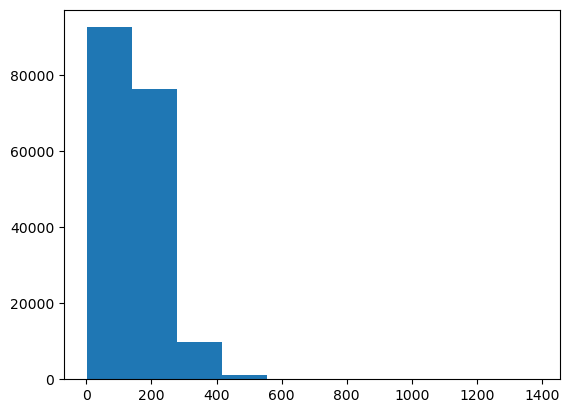

In [48]:
import matplotlib.pyplot as plt
plt.hist(character_lengths, bins=10);

In [34]:
output_sequence_character_length = int(np.percentile(character_lengths, 95))
output_sequence_character_length # covers 95% of sequences

290

In [35]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation

n_character_tokens = len(alphabet) + 2

character_vectoriser = TextVectorization(max_tokens=n_character_tokens,
                                         output_sequence_length=output_sequence_character_length,
                                         standardize='lower_and_strip_punctuation',
                                         name='character_vectoriser')

character_vectoriser.adapt(train_characters)


In [36]:
character_vocab = character_vectoriser.get_vocabulary()
print(f"Number of different characters in character vocab: {len(character_vocab)}")
print(f"5 most common characters: {character_vocab[:5]}")
print(f"5 least common characters: {character_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [38]:
random_train_characters = random.choice(train_characters)
print(f"Charified text:\n{random_train_characters}")
print(f"\nLength of chars: {len(random_train_characters.split())}")
vectorized_characters = character_vectoriser([random_train_characters])
print(f"\nVectorized chars:\n{vectorized_characters}")
print(f"\nLength of vectorized chars: {len(vectorized_characters[0])}")

Charified text:
t o   e v a l u a t e   t h e   e f f i c a c y   a n d   s a f e t y   o f   s o l i f e n a c i n   i n   t h e   m a n a g e m e n t   o f   i r r i t a t i v e   s y m p t o m s   a f t e r   t r a n s u r e t h r a l   r e s e c t i o n   o f   b l a d d e r   t u m o r s   (   t u r b t s   )   w i t h   s u b s e q u e n t   i n t r a v e s i c a l   c h e m o t h e r a p y   .

Length of chars: 167

Vectorized chars:
[[ 3  7  2 21  5 12 16  5  3  2  3 13  2  2 17 17  4 11  5 11 19  5  6 10
   9  5 17  2  3 19  7 17  9  7 12  4 17  2  6  5 11  4  6  4  6  3 13  2
  15  5  6  5 18  2 15  2  6  3  7 17  4  8  8  4  3  5  3  4 21  2  9 19
  15 14  3  7 15  9  5 17  3  2  8  3  8  5  6  9 16  8  2  3 13  8  5 12
   8  2  9  2 11  3  4  7  6  7 17 22 12  5 10 10  2  8  3 16 15  7  8  9
   3 16  8 22  3  9 20  4  3 13  9 16 22  9  2 26 16  2  6  3  4  6  3  8
   5 21  2  9  4 11  5 12 11 13  2 15  7  3 13  2  8  5 14 19  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0

In [39]:
character_embedder = layers.Embedding(input_dim=n_character_tokens,
                                      output_dim=25,
                                      mask_zero=False,
                                      name='character_embedder')

print(f"Charified text (before vectorization and embedding):\n{random_train_characters}\n")
character_embed_example = character_embedder(character_vectoriser([random_train_characters]))
print(f"Embedded chars (after vectorization and embedding):\n{character_embed_example}\n")
print(f"Character embedding shape: {character_embed_example.shape}")
     

Charified text (before vectorization and embedding):
t o   e v a l u a t e   t h e   e f f i c a c y   a n d   s a f e t y   o f   s o l i f e n a c i n   i n   t h e   m a n a g e m e n t   o f   i r r i t a t i v e   s y m p t o m s   a f t e r   t r a n s u r e t h r a l   r e s e c t i o n   o f   b l a d d e r   t u m o r s   (   t u r b t s   )   w i t h   s u b s e q u e n t   i n t r a v e s i c a l   c h e m o t h e r a p y   .

Embedded chars (after vectorization and embedding):
[[[-0.01462697  0.00197525 -0.01497126 ...  0.02365531  0.02893413
    0.0019393 ]
  [-0.01467118  0.0481994  -0.01437579 ...  0.00124412  0.03345894
   -0.02051021]
  [-0.04996848 -0.00753636 -0.009287   ...  0.01880212 -0.03284983
   -0.00934274]
  ...
  [-0.00473616 -0.00783391  0.02192047 ...  0.04359369  0.00333639
    0.03824076]
  [-0.00473616 -0.00783391  0.02192047 ...  0.04359369  0.00333639
    0.03824076]
  [-0.00473616 -0.00783391  0.02192047 ...  0.04359369  0.00333639
    0.03824076]]]


In [40]:
train_character_dataset = tf.data.Dataset.from_tensor_slices((train_characters, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_character_dataset = tf.data.Dataset.from_tensor_slices((val_characters, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_character_dataset = tf.data.Dataset.from_tensor_slices((test_characters, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)


In [55]:
def model3():
    inputs = layers.Input(shape=(1,), dtype='string')
    character_vectors = character_vectoriser(inputs)
    character_embeddings = character_embedder(character_vectors)
    x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(character_embeddings)
    x = layers.GlobalMaxPool1D()(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs, outputs)
    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.legacy.Adam(),
                  metrics=['accuracy'])
    
    model.summary()
    history = model.fit(train_character_dataset,
                        steps_per_epoch=int(0.1*len(train_character_dataset)), # look at only 10% of the data while experimenting
                        validation_data=val_character_dataset,
                        validation_steps=int(0.1*len(val_character_dataset)),
                        epochs=3
                       )
    
    model_predict_probs = model.predict(val_character_dataset)
    model_preds = tf.argmax(model_predict_probs, axis=1)
    
    model_results = calculate_results(y_true=val_labels_encoded, y_pred=model_preds)
    
    return history, model_results 

In [56]:
_, model3_results = model3()
model3_results

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 character_vectoriser (Text  (None, 290)               0         
 Vectorization)                                                  
                                                                 
 character_embedder (Embedd  (None, 290, 25)           1750      
 ing)                                                            
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                           

{'accuracy': 66.1624520058255,
 'precision': 0.6522035351788926,
 'recall': 0.661624520058255,
 'f1': 0.6515357920604705}

## 4. Pretrained Token Embeddings + Character Level Embeddings

In [33]:
from tensorflow.keras.utils import plot_model

In [58]:
def model4(train_dataset=None, val_dataset=None):
    use_embedding_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2",
                               input_shape=[],
                               dtype=tf.string)
    
    token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_input')
    token_embeddings = use_embedding_layer(token_inputs)
    token_output = layers.Dense(128, activation='relu')(token_embeddings)
    token_model = tf.keras.Model(inputs=token_inputs, outputs=token_output)
    
    character_inputs = layers.Input(shape=(1,), dtype=tf.string, name='character_input')
    character_vectors = character_vectoriser(character_inputs)
    character_embeddings = character_embedder(character_vectors)
    character_bi_lstm = layers.Bidirectional(layers.LSTM(24))(character_embeddings)
    character_model = tf.keras.Model(inputs=character_inputs, outputs=character_bi_lstm)
    
    token_character_concat = layers.Concatenate(name='tok_ch_hybrid')([token_model.output,
                                                                       character_model.output])
    
    combined_dropout = layers.Dropout(0.5)(token_character_concat)
    combined_dense = layers.Dense(200, activation='relu')(combined_dropout)
    final_dropout = layers.Dropout(0.5)(combined_dense)
    output_layer = layers.Dense(n_classes, activation='softmax')(final_dropout)
    
    model = tf.keras.Model(inputs=[token_model.input, character_model.input],
                            outputs=output_layer,
                            name='model4')
    
    model.summary()
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.legacy.Adam(),
                  metrics=['accuracy'])
    history = model.fit(train_dataset,
                        steps_per_epoch=int(0.1*len(train_dataset)), # look at only 10% of the data while experimenting
                        validation_data=val_dataset,
                        validation_steps=int(0.1*len(val_dataset)),
                        epochs=5
                       )
    
    model_predict_probs = model.predict(val_dataset)
    model_preds = tf.argmax(model_predict_probs, axis=1)
    
    model_results = calculate_results(y_true=val_labels_encoded, y_pred=model_preds)
    
    return history, model_results, model

In [59]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_characters))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 


val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_characters))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [60]:
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [61]:
_, model4_results, model_4 = model4(train_dataset=train_char_token_dataset,
                           val_dataset=val_char_token_dataset)
model4_results

Model: "model4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 character_input (InputLaye  [(None, 1)]                  0         []                            
 r)                                                                                               
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 character_vectoriser (Text  (None, 290)                  0         ['character_input[0][0]']     
 Vectorization)                                                                                   
                                                                                             

{'accuracy': 69.22414934463127,
 'precision': 0.7079473247310019,
 'recall': 0.6922414934463127,
 'f1': 0.6895298913868865}

## lol smh

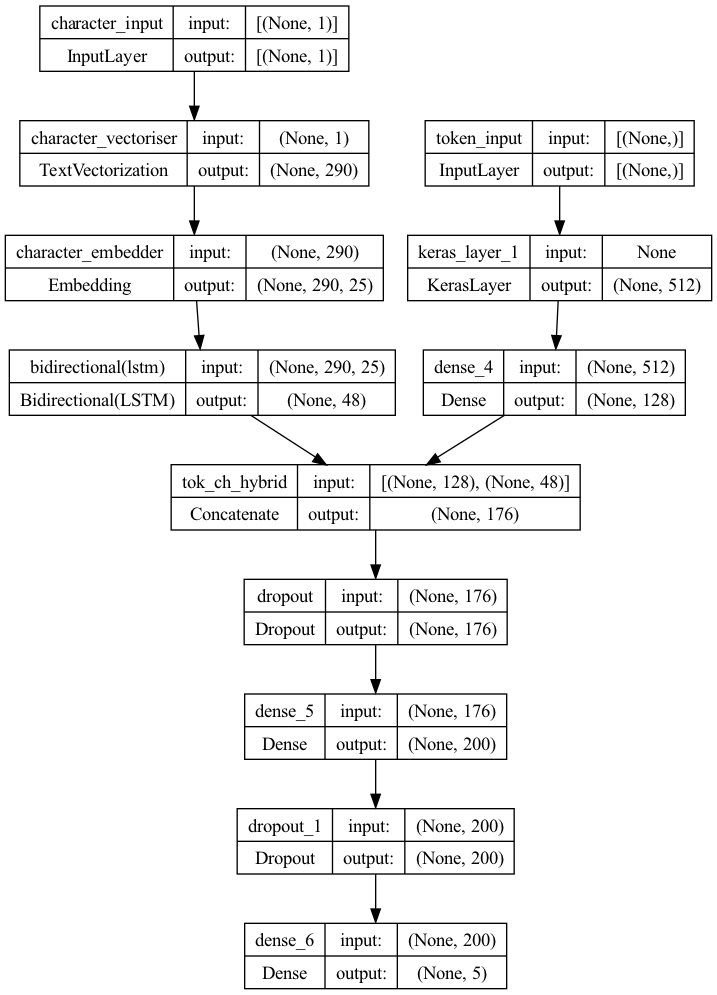

In [62]:
plot_model(model_4, show_shapes=True)

## 5. Pretrained Token Embeddings + Character Level Embeddings + Positional Embeddings

In [63]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [64]:
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

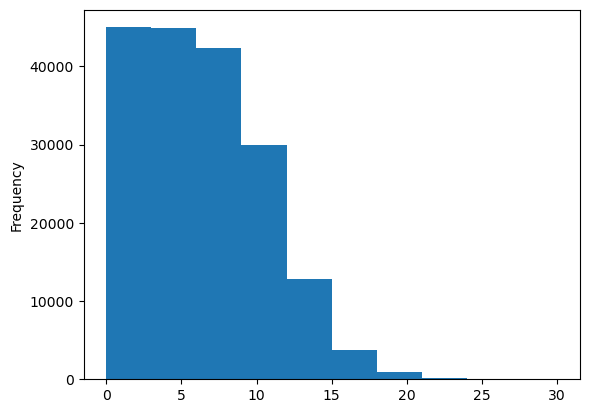

In [65]:
train_df['line_number'].plot.hist()

In [44]:
train_line_numbers_onehot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers_onehot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_numbers_onehot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)
train_line_numbers_onehot[:15]

<tf.Tensor: shape=(15, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [45]:
train_line_numbers_onehot.shape

TensorShape([180040, 15])

In [46]:
np.percentile(train_df.total_lines, 98)

20.0

In [47]:
train_total_lines_onehot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_lines_onehot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_lines_onehot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)
train_total_lines_onehot[:15]

<tf.Tensor: shape=(15, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
     

In [52]:
def model5(train_dataset=None, val_dataset=None):
    use_embedding_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2",
                               input_shape=[],
                               dtype=tf.string)
    
    token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_input')
    token_embeddings = use_embedding_layer(token_inputs)
    token_output = layers.Dense(128, activation='relu')(token_embeddings)
    token_model = tf.keras.Model(inputs=token_inputs, outputs=token_output)
    
    character_inputs = layers.Input(shape=(1,), dtype=tf.string, name='character_input')
    character_vectors = character_vectoriser(character_inputs)
    character_embeddings = character_embedder(character_vectors)
    character_bi_lstm = layers.Bidirectional(layers.LSTM(24))(character_embeddings)
    character_model = tf.keras.Model(inputs=character_inputs, outputs=character_bi_lstm)
    
    line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name='line_number_inputs')
    x = layers.Dense(32, activation='relu')(line_number_inputs)
    line_number_model = tf.keras.Model(inputs=line_number_inputs, outputs=x)
    
    total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name='total_lines_inputs')
    y = layers.Dense(32, activation='relu')(total_lines_inputs)
    total_lines_model = tf.keras.Model(inputs=total_lines_inputs, outputs=y)
    
    concatenated_embeddings = layers.Concatenate(name='tok_ch_hybrid')([token_model.output,
                                                                       character_model.output])
    
    final = layers.Dense(256, activation='relu')(concatenated_embeddings)
    final = layers.Dropout(0.5)(final)
    final = layers.Concatenate(name='token_char_pos_embedding')([line_number_model.output,
                                                                 total_lines_model.output,
                                                                 final])
    
    output_layer = layers.Dense(n_classes, activation='softmax')(final)
    
    model = tf.keras.Model(inputs=[line_number_model.input,
                                   total_lines_model.input,
                                   token_model.input, 
                                   character_model.input],
                            outputs=output_layer,
                            name='model5')
    
    model.summary()
    
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                  optimizer=tf.keras.optimizers.legacy.Adam(),
                  metrics=['accuracy'])
    history = model.fit(train_dataset,
                        steps_per_epoch=int(0.1*len(train_dataset)),
                        validation_data=val_dataset,
                        validation_steps=int(0.1*len(val_dataset)),
                        epochs=4
                       )
    model.save('beast')
    model_predict_probs = model.predict(val_dataset)
    model_preds = tf.argmax(model_predict_probs, axis=1)
    
    model_results = calculate_results(y_true=val_labels_encoded, y_pred=model_preds)
    
    
    return history, model_results

In [49]:
# Prep data. Again...

train_pos_char_tok_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_onehot,
                                                              train_total_lines_onehot,
                                                              train_sentences,
                                                              train_characters))
train_pos_char_tok_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_pos_char_tok_dataset = tf.data.Dataset.zip((train_pos_char_tok_data, 
                                                  train_pos_char_tok_labels))
train_pos_char_tok_dataset = train_pos_char_tok_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_pos_char_tok_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_onehot,
                                                              val_total_lines_onehot,
                                                              val_sentences,
                                                              val_characters))
val_pos_char_tok_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_tok_dataset = tf.data.Dataset.zip((val_pos_char_tok_data, 
                                                  val_pos_char_tok_labels))
val_pos_char_tok_dataset = val_pos_char_tok_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_pos_char_tok_dataset, val_pos_char_tok_dataset


(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [53]:
_, model5_results = model5(train_dataset=train_pos_char_tok_dataset,
                           val_dataset=val_pos_char_tok_dataset)
model5_results

Model: "model5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 character_input (InputLaye  [(None, 1)]                  0         []                            
 r)                                                                                               
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 character_vectoriser (Text  (None, 290)                  0         ['character_input[0][0]']     
 Vectorization)                                                                                   
                                                                                             

INFO:tensorflow:Assets written to: beast/assets


945/945 [==============================] - 119s 124ms/step


{'accuracy': 78.65086720508407,
 'precision': 0.7987440916784735,
 'recall': 0.7865086720508407,
 'f1': 0.7839099889218597}

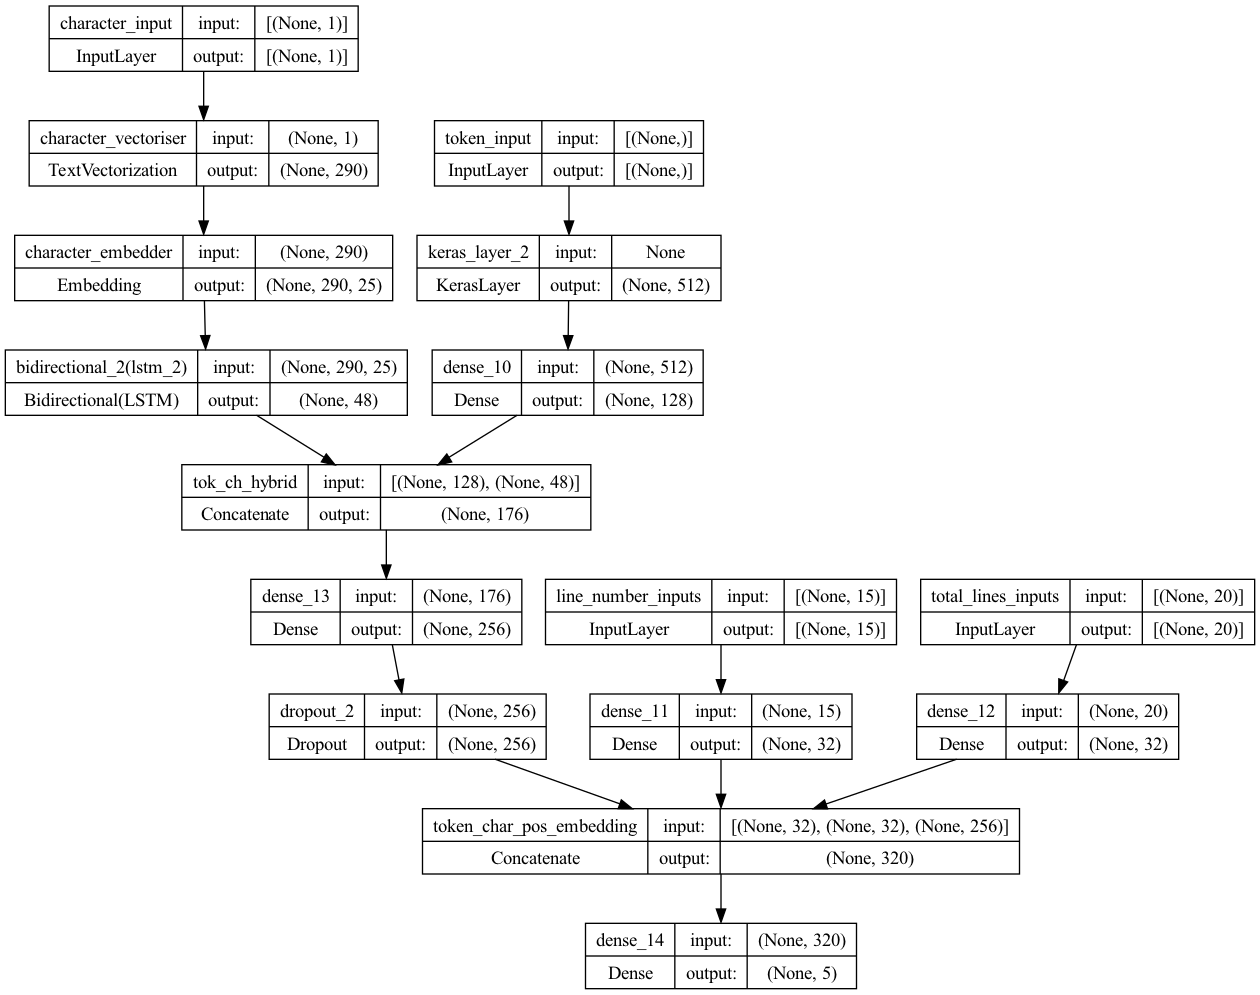

In [51]:
model_5 = tf.keras.models.load_model('beast')
plot_model(model_5, show_shapes=True)

In [52]:
test_pos_char_tok_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_onehot,
                                                              test_total_lines_onehot,
                                                              test_sentences,
                                                              test_characters))
test_pos_char_tok_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_tok_dataset = tf.data.Dataset.zip((test_pos_char_tok_data, 
                                                  test_pos_char_tok_labels))
test_pos_char_tok_dataset = test_pos_char_tok_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [53]:
model_5_predict_probs = model_5.predict(test_pos_char_tok_dataset)
model_5_preds = tf.argmax(model_5_predict_probs, axis=1)
    
model_5_results = calculate_results(y_true=test_labels_encoded, y_pred=model_5_preds)

942/942 [==============================] - 211s 220ms/step


In [54]:
model_5_results

{'accuracy': 78.01559648249544,
 'precision': 0.793128214457675,
 'recall': 0.7801559648249544,
 'f1': 0.7741701630245323}